<a href="https://colab.research.google.com/github/UzunDemir/19.2.-Anomaly-detection-with-visualization/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача классификации текста с использованием архитектуры LSTM.

Датасет IMDB Dataset of 50K Movie Reviews:

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

**review:** отзыв.

**sentiment:** позитивный или негативный.


In [ ]:
!pip install torchtext==0.6

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import matplotlib.pyplot as plt

import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

In [24]:
!pip install kaggle

In [25]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
import zipfile
import os

# Путь к вашему архиву fake-news.zip
zip_file = '/content/imdb-dataset-of-50k-movie-reviews.zip'

# Папка, куда вы хотите распаковать файлы
extract_dir = '/content/imdb-dataset-of-50k-movie-reviews'

# Распаковка архива
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Вывод содержимого распакованной папки
os.listdir(extract_dir)

['IMDB Dataset.csv']

In [27]:
df = pd.read_csv(r'/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv', encoding='utf-8')

In [30]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


data = df

In [28]:
# Определите поля (fields)
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
# Создайте список примеров
examples = []
for index, row in df.iterrows():
    text = row['review']
    label = row['sentiment']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [ ]:
# Создайте Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [ ]:
# Задайте seed для воспроизводимости
SEED = 42
random.seed(SEED)

# Разбейте на тренировочный и тестовый наборы данных
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [ ]:
# Построение словаря
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
# Определение BATCH_SIZE и указание, что при наличии GPU вычисления будут выполняться на нём
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Создаём итератор
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text))

In [ ]:
# Определяем модель
class AttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden.squeeze(0))

In [ ]:
# Определяем параметры модели
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.5

In [ ]:
model = AttentionModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Вычисляем accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_loss, val_acc.item()

In [ ]:
N_EPOCHS = 10

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


 10%|█         | 1/10 [00:17<02:37, 17.52s/it]

Epoch: 01, Train Loss: 0.683, Train Acc: 55.54%, Val Loss: 0.682, Val Acc: 55.55%


 20%|██        | 2/10 [00:33<02:10, 16.32s/it]

Epoch: 02, Train Loss: 0.605, Train Acc: 68.24%, Val Loss: 0.605, Val Acc: 68.24%


 30%|███       | 3/10 [00:48<01:52, 16.11s/it]

Epoch: 03, Train Loss: 0.505, Train Acc: 76.77%, Val Loss: 0.505, Val Acc: 76.77%


 40%|████      | 4/10 [01:04<01:36, 16.02s/it]

Epoch: 04, Train Loss: 0.417, Train Acc: 82.28%, Val Loss: 0.417, Val Acc: 82.29%


 50%|█████     | 5/10 [01:20<01:18, 15.78s/it]

Epoch: 05, Train Loss: 0.350, Train Acc: 85.80%, Val Loss: 0.350, Val Acc: 85.80%


 60%|██████    | 6/10 [01:35<01:02, 15.65s/it]

Epoch: 06, Train Loss: 0.318, Train Acc: 87.29%, Val Loss: 0.319, Val Acc: 87.29%


 70%|███████   | 7/10 [01:50<00:46, 15.56s/it]

Epoch: 07, Train Loss: 0.299, Train Acc: 88.20%, Val Loss: 0.299, Val Acc: 88.20%


 80%|████████  | 8/10 [02:06<00:31, 15.67s/it]

Epoch: 08, Train Loss: 0.257, Train Acc: 90.12%, Val Loss: 0.257, Val Acc: 90.11%


 90%|█████████ | 9/10 [02:22<00:15, 15.63s/it]

Epoch: 09, Train Loss: 0.311, Train Acc: 87.31%, Val Loss: 0.311, Val Acc: 87.32%


100%|██████████| 10/10 [02:38<00:00, 15.84s/it]

Epoch: 10, Train Loss: 0.253, Train Acc: 90.19%, Val Loss: 0.253, Val Acc: 90.19%


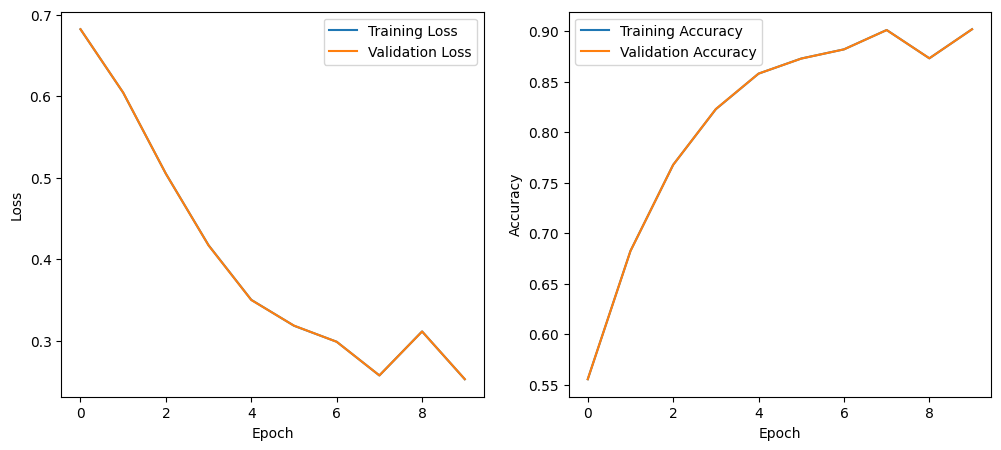

In [ ]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Сохранение модели
# torch.save(model.state_dict(), 'model_pytorch.pt' )

In [ ]:
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████| 334/334 [00:01<00:00, 293.53it/s]


Accuracy: 0.8834
F1 Score: 0.8800164642930645
ROC AUC Score: 0.945817524109067


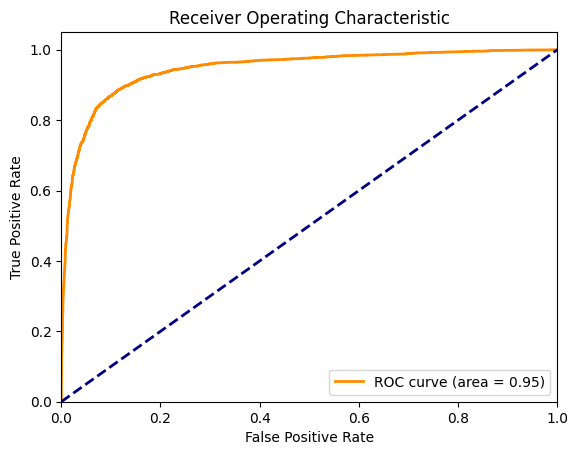

In [ ]:
evaluate_model(model, test_iterator)